In [21]:
import torch
import torchvision
import torchvision.transforms as transforms
from torch.utils.data import Dataset, DataLoader
import numpy as np
import matplotlib.pyplot as plt

In [22]:
class CustomDataset(Dataset):
    def __init__(self, images_file, labels_file, transform=None):
        self.images = self.load_images(images_file)
        self.labels = self.load_labels(labels_file)
        self.transform = transform

    def __len__(self):
        return len(self.labels)

    def __getitem__(self, idx):
        image = self.images[idx]
        label = self.labels[idx]
        if self.transform:
            image = self.transform(image)
        return image, label

    def load_images(self, file_path):
        with open(file_path, 'rb') as f:
            data = np.frombuffer(f.read(), dtype=np.uint8, offset=16)  # Skip first 16 bytes
        num_images = len(data) // (28 * 28)
        data = data.reshape(num_images, 28, 28)
        return data.copy()  # Ensure the array is writable

    def load_labels(self, file_path):
        with open(file_path, 'rb') as f:
            data = np.frombuffer(f.read(), dtype=np.uint8, offset=8)  # Skip first 8 bytes
        return data

In [23]:
train_images_file = "dataset/train-images-idx3-ubyte"
train_labels_file = "dataset/train-labels-idx1-ubyte"
validation_images_file = "dataset/validation-images-idx3-ubyte"
validation_labels_file = "dataset/validation-labels-idx1-ubyte"

batch_size = 4

transform = transforms.Compose(
    [transforms.ToTensor(),
     transforms.Normalize(0.5, 0.5)])

train_set = CustomDataset(train_images_file, train_labels_file, transform=transform)
validation_set = CustomDataset(validation_images_file, validation_labels_file, transform=transform)

validation_loader = DataLoader(validation_set, batch_size=batch_size, shuffle=True)
train_loader = DataLoader(train_set, batch_size=batch_size, shuffle=True)

'''
train_set = torchvision.datasets.MNIST(root='./data', train=True,
                                        download=True, transform=transform)
validation_set = torchvision.datasets.MNIST(root='./data', train=False,
                                        download=True, transform=transform)

validation_loader = torch.utils.data.DataLoader(validation_set, batch_size=batch_size,
                                         shuffle=False, num_workers=2)
train_loader = torch.utils.data.DataLoader(train_set, batch_size=batch_size,
                                          shuffle=True, num_workers=2)
'''

"\ntrain_set = torchvision.datasets.MNIST(root='./data', train=True,\n                                        download=True, transform=transform)\nvalidation_set = torchvision.datasets.MNIST(root='./data', train=False,\n                                        download=True, transform=transform)\n\nvalidation_loader = torch.utils.data.DataLoader(validation_set, batch_size=batch_size,\n                                         shuffle=False, num_workers=2)\ntrain_loader = torch.utils.data.DataLoader(train_set, batch_size=batch_size,\n                                          shuffle=True, num_workers=2)\n"

In [24]:
with open('dictionnary_labels.txt', 'r') as file:
    lines = file.readlines()

map_dict = {}

for line in lines:
    line = line.strip()
    key, value = line.split('_')
    map_dict[int(key) - 1] = value

print(map_dict[0])

"""
map_dict = {0: "0", 1: "1", 2: "2", 3: "3", 4: "4", 5: "5", 6: "6", 7: "7", 8: "8", 9: "9"}
print(map_dict[0])
"""

Alef


'\nmap_dict = {0: "0", 1: "1", 2: "2", 3: "3", 4: "4", 5: "5", 6: "6", 7: "7", 8: "8", 9: "9"}\nprint(map_dict[0])\n'

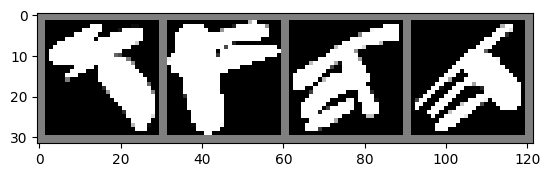

Waw   Alef  Hey   Hey  


In [25]:
def imshow(img):
    img = img / 2 + 0.5     # unnormalize
    npimg = img.numpy()
    plt.imshow(np.transpose(npimg, (1, 2, 0)))
    plt.show()


# get some random training images
dataiter = iter(train_loader)
images, labels = next(dataiter)

# show images
imshow(torchvision.utils.make_grid(images))
# print labels
print(' '.join(f'{map_dict[int(labels[j])]:5s}' for j in range(batch_size)))

In [26]:
import torch.nn as nn
import torch.nn.functional as F


class Net(nn.Module):
    def __init__(self):
        super().__init__()
        self.conv1 = nn.Conv2d(1, 6, 5)
        self.pool = nn.MaxPool2d(2, 2)
        self.conv2 = nn.Conv2d(6, 16, 5)
        self.fc1 = nn.Linear(16 * 4 * 4, 120)
        self.fc2 = nn.Linear(120, 84)
        self.fc3 = nn.Linear(84, 22)

    def forward(self, x):
        x = self.pool(F.relu(self.conv1(x)))
        x = self.pool(F.relu(self.conv2(x)))
        x = torch.flatten(x, 1) # flatten all dimensions except batch
        x = F.relu(self.fc1(x))
        x = F.relu(self.fc2(x))
        x = self.fc3(x)
        return x

net = Net()

In [27]:
import torch.optim as optim

criterion = nn.CrossEntropyLoss()
optimizer = optim.SGD(net.parameters(), lr=0.001, momentum=0.9)

In [28]:
for epoch in range(15):  # loop over the dataset multiple times

    running_loss = 0.0
    for i, data in enumerate(train_loader, 0):
        # get the inputs; data is a list of [inputs, labels]
        inputs, labels = data

        # zero the parameter gradients
        optimizer.zero_grad()

        # forward + backward + optimize
        outputs = net(inputs)
        loss = criterion(outputs, labels)
        loss.backward()
        optimizer.step()

        # print statistics
        running_loss += loss.item()
        if i % 11 == 0:    # print every 2 mini-batches for this example
            print(f'[{epoch + 1}, {i + 1:5d}] loss: {running_loss / 2:.3f}')
            running_loss = 0.0

print('Finished Training')

PATH = './PNA_net.pth'
torch.save(net.state_dict(), PATH)

[1,     1] loss: 1.584
[1,    12] loss: 17.175
[1,    23] loss: 17.042
[1,    34] loss: 16.926
[1,    45] loss: 16.781
[1,    56] loss: 16.654
[1,    67] loss: 16.534
[1,    78] loss: 16.332
[1,    89] loss: 16.063
[2,     1] loss: 1.439
[2,    12] loss: 15.662
[2,    23] loss: 14.775
[2,    34] loss: 13.862
[2,    45] loss: 13.082
[2,    56] loss: 11.917
[2,    67] loss: 10.645
[2,    78] loss: 10.456
[2,    89] loss: 10.157
[3,     1] loss: 1.025
[3,    12] loss: 10.013
[3,    23] loss: 9.716
[3,    34] loss: 9.483
[3,    45] loss: 9.296
[3,    56] loss: 8.564
[3,    67] loss: 8.311
[3,    78] loss: 8.736
[3,    89] loss: 7.823
[4,     1] loss: 0.581
[4,    12] loss: 6.425
[4,    23] loss: 6.736
[4,    34] loss: 6.293
[4,    45] loss: 5.492
[4,    56] loss: 6.113
[4,    67] loss: 5.578
[4,    78] loss: 5.570
[4,    89] loss: 6.522
[5,     1] loss: 0.137
[5,    12] loss: 5.812
[5,    23] loss: 5.232
[5,    34] loss: 4.275
[5,    45] loss: 5.662
[5,    56] loss: 5.498
[5,    67] loss: 

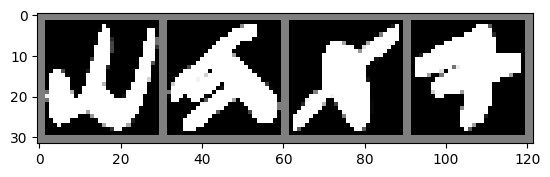

Shin  Hey   Tav   Yod  


In [29]:
dataiter = iter(validation_loader)
images, labels = next(dataiter)

# print images
imshow(torchvision.utils.make_grid(images))
print(' '.join(f'{map_dict[int(labels[j])]:5s}' for j in range(batch_size)))

In [30]:
net = Net()
net.load_state_dict(torch.load(PATH))

<All keys matched successfully>

In [31]:
outputs = net(images)

In [32]:
_, predicted = torch.max(outputs, 1)

print('Predicted: ', ' '.join(f'{map_dict[int(predicted[j])]:5s}'
                              for j in range(batch_size)))

Predicted:  Shin  Hey   Tav   Yod  
